<a href="https://colab.research.google.com/github/HSavich/dialect_discrimination/blob/master/dialect_discrimination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets
!pip install datasets[audio]
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 13.3 MB/s 
     |████████████████████████████████| 451 kB 97.9 MB/s 
     |████████████████████████████████| 182 kB 88.1 MB/s 
     |████████████████████████████████| 7.6 MB 60.1 MB/s 
     |████████████████████████████████| 212 kB 99.1 MB/s 
     |████████████████████████████████| 132 kB 97.3 MB/s 
     |████████████████████████████████| 127 kB 95.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Construct the dataset

In [2]:
from datasets import load_dataset, interleave_datasets, Audio, concatenate_datasets
from IPython.display import Audio as ipd_audio
import numpy as np

In [3]:
id2label = dict()

def load_openslr_ds(ds_id, id_num, label_name):
  id2label[id_num] = label_name

  ds = load_dataset('openslr', ds_id, split = 'train')
  ds_labels = [id_num] * len(ds)
  ds = ds.add_column("label", ds_labels)
  speakers = [path[119:128] for path in ds['path']]
  ds = ds.add_column("speaker", speakers)
  return(ds)

In [4]:
dialect_set = [('SLR71', 'Chile'),
               ('SLR72', 'Colombia'),
               ('SLR73', 'Peru'),
               ('SLR74', 'Puerto Rico'),
               ('SLR75', 'Venezuela'),
               ('SLR76', 'Basque')]

In [5]:
#takes 9m
ds_s = []
for i, tpl in enumerate(dialect_set):
  ds_s.append(load_openslr_ds(tpl[0], i, tpl[1]))
dialects = interleave_datasets(ds_s).remove_columns(["sentence","path"])

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/4374 [00:00<?, ? examples/s]

Dataset openslr downloaded and prepared to /root/.cache/huggingface/datasets/openslr/SLR71/0.0.0/cd9de085f77465c1cb7d394e748a3a5b80fad2049e7af92f67baf04b894f9567. Subsequent calls will reuse this data.


Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/4903 [00:00<?, ? examples/s]

Dataset openslr downloaded and prepared to /root/.cache/huggingface/datasets/openslr/SLR72/0.0.0/cd9de085f77465c1cb7d394e748a3a5b80fad2049e7af92f67baf04b894f9567. Subsequent calls will reuse this data.


Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/5447 [00:00<?, ? examples/s]

Dataset openslr downloaded and prepared to /root/.cache/huggingface/datasets/openslr/SLR73/0.0.0/cd9de085f77465c1cb7d394e748a3a5b80fad2049e7af92f67baf04b894f9567. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/617 [00:00<?, ? examples/s]

Dataset openslr downloaded and prepared to /root/.cache/huggingface/datasets/openslr/SLR74/0.0.0/cd9de085f77465c1cb7d394e748a3a5b80fad2049e7af92f67baf04b894f9567. Subsequent calls will reuse this data.


Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/3357 [00:00<?, ? examples/s]

Dataset openslr downloaded and prepared to /root/.cache/huggingface/datasets/openslr/SLR75/0.0.0/cd9de085f77465c1cb7d394e748a3a5b80fad2049e7af92f67baf04b894f9567. Subsequent calls will reuse this data.


Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/7136 [00:00<?, ? examples/s]

Dataset openslr downloaded and prepared to /root/.cache/huggingface/datasets/openslr/SLR76/0.0.0/cd9de085f77465c1cb7d394e748a3a5b80fad2049e7af92f67baf04b894f9567. Subsequent calls will reuse this data.


In [6]:
ipd_audio(dialects[0]['audio']['array'], rate = 48_000)

In [7]:
dialects = dialects.cast_column("audio", Audio(sampling_rate=16_000))

In [8]:
ipd_audio(dialects[0]['audio']['array'], rate = 16_000)

# Extract Features

In [9]:
from transformers import AutoFeatureExtractor

In [10]:
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base");

Downloading:   0%|          | 0.00/159 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/configuration_utils.py:369: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [11]:
dir(feature_extractor)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_class',
 '_create_repo',
 '_get_files_timestamps',
 '_get_padding_strategies',
 '_pad',
 '_processor_class',
 '_set_processor_class',
 '_truncate',
 '_upload_modified_files',
 'do_normalize',
 'feature_size',
 'from_dict',
 'from_json_file',
 'from_pretrained',
 'get_feature_extractor_dict',
 'model_input_names',
 'pad',
 'padding_side',
 'padding_value',
 'push_to_hub',
 'register_for_auto_class',
 'return_attention_mask',
 'sampling_rate',
 'save_pretrained',
 'to_dict',
 'to_json_file',
 'to_json_string',
 'zero_mean_unit_var_norm']

In [12]:
feature_extractor

Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}

In [13]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays, sampling_rate=feature_extractor.sampling_rate, 
        max_length=80000, truncation=True
    )
    return inputs

In [14]:
dialects = dialects.map(preprocess_function, remove_columns="audio", batched=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

/usr/local/lib/python3.8/dist-packages/transformers/feature_extraction_utils.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)


# Train-Test Split on Speakers

In [15]:
test_split_pct = 0.2

Choose which speakers get put in the test set and which get put in the train set:

In [16]:
test_split_pct = 0.2

speakers = np.array(dialects['speaker'])
unique_speakers = np.unique(speakers)
test_speaker_ids = []

#stratify sampling by speaker country so every country gets represented in test set
strata = ['co','cl','eu','pr','pe','ve']

for stratum in strata:
  this_stratum = np.array([s for s in unique_speakers if s.startswith(stratum)])
  test_size = int(len(this_stratum) * test_split_pct)
  test_speakers = np.random.choice(this_stratum, test_size)
  test_speaker_ids.extend(test_speakers.tolist())

In [17]:
unique_speakers

array(['clf_00610', 'clf_01523', 'clf_02484', 'clf_03397', 'clf_04310',
       'clf_05223', 'clf_06136', 'clf_07049', 'clf_07508', 'clf_08421',
       'clf_08784', 'clf_09334', 'clf_09697', 'cof_00610', 'cof_01523',
       'cof_02436', 'cof_02484', 'cof_03034', 'cof_03349', 'cof_03397',
       'cof_04310', 'cof_05223', 'cof_06136', 'cof_07049', 'cof_07508',
       'cof_08421', 'cof_08784', 'cof_09334', 'cof_09697', 'euf_00295',
       'euf_00610', 'euf_00712', 'euf_01208', 'euf_01523', 'euf_02121',
       'euf_02436', 'euf_02484', 'euf_03034', 'euf_03349', 'euf_03397',
       'euf_03502', 'euf_03853', 'euf_04310', 'euf_04415', 'euf_04766',
       'euf_05679', 'euf_06592', 'euf_07049', 'euf_07060', 'euf_07505',
       'euf_07508', 'euf_07973', 'euf_08421', 'euf_08784', 'euf_08886',
       'euf_09334', 'euf_09697', 'euf_09799', 'pef_00610', 'pef_01208',
       'pef_01523', 'pef_02121', 'pef_02436', 'pef_02484', 'pef_03034',
       'pef_03349', 'pef_03397', 'pef_04310', 'pef_05223', 'pef_

In [18]:
test_speaker_ids

['cof_09697',
 'cof_02484',
 'cof_07508',
 'clf_07508',
 'clf_08421',
 'euf_07505',
 'euf_02484',
 'euf_08784',
 'euf_01523',
 'euf_04766',
 'prf_04310',
 'pef_06136',
 'pef_00610',
 'pef_09697',
 'vef_07508',
 'vef_07508']

Get the indices of the splits and split the dataset

In [19]:
test_indices = []
train_indices = []

for i, speaker_id in enumerate(speakers):
  if speaker_id in test_speaker_ids:
    test_indices.append(i)
  else:
    train_indices.append(i)

test = dialects.select(test_indices)
train = dialects.select(train_indices)

# Model Train

In [20]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

In [21]:
model = AutoModelForAudioClassification.from_pretrained(
    "facebook/wav2vec2-base", num_labels=6)

/usr/local/lib/python3.8/dist-packages/transformers/configuration_utils.py:369: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Downloading:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2ForSequenceClassification: ['project_hid.bias', 'project_q.bias', 'quantizer.codevectors', 'quantizer.weight_proj.weight', 'project_hid.weight', 'project_q.weight', 'quantizer.weight_proj.bias']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['projector.weight', 'classifier.weight', 'classifi

In [22]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    logging_steps=250,
    save_strategy="epoch",
    learning_rate=3e-5,
    num_train_epochs=7,
)

In [23]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset = train,
    eval_dataset=test,
    tokenizer=feature_extractor)

In [24]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `Wav2Vec2ForSequenceClassification.forward` and have been ignored: speaker. If speaker are not expected by `Wav2Vec2ForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3135
  Num Epochs = 7
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2744
  Number of trainable parameters = 94570118


Step,Training Loss,Validation Loss
250,1.054300,0.674142
500,0.211600,0.428415
750,0.080500,1.014109
1000,0.034200,0.828646
1250,0.032400,0.975466
1500,0.025500,0.662792
1750,0.016900,1.500699
2000,0.014300,1.293597
2250,0.007100,0.947282
2500,0.001700,1.184629


The following columns in the evaluation set don't have a corresponding argument in `Wav2Vec2ForSequenceClassification.forward` and have been ignored: speaker. If speaker are not expected by `Wav2Vec2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 567
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-392
Configuration saved in ./results/checkpoint-392/config.json
Model weights saved in ./results/checkpoint-392/pytorch_model.bin
Feature extractor saved in ./results/checkpoint-392/preprocessor_config.json
The following columns in the evaluation set don't have a corresponding argument in `Wav2Vec2ForSequenceClassification.forward` and have been ignored: speaker. If speaker are not expected by `Wav2Vec2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 567
  Batch size = 8
The following columns in the evaluation set don't have a corres

TrainOutput(global_step=2744, training_loss=0.13478721767859453, metrics={'train_runtime': 1481.8674, 'train_samples_per_second': 14.809, 'train_steps_per_second': 1.852, 'total_flos': 9.961637949648e+17, 'train_loss': 0.13478721767859453, 'epoch': 7.0})

In [35]:
trainer.save_model("/accent_determinator")

Saving model checkpoint to /accent_determinator
Configuration saved in /accent_determinator/config.json
Model weights saved in /accent_determinator/pytorch_model.bin
Feature extractor saved in /accent_determinator/preprocessor_config.json


In [39]:
!cp -r /accent_determinator "/content/drive/My Drive/"

cp: cannot create directory '/content/drive/My Drive/': No such file or directory


In [ ]:
files.download('/accent_determinator')

In [38]:
from google.colab import files

# Evaluate Model

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [26]:
pred = trainer.predict(test)

yhat = np.argmax(pred.predictions, axis = 1)

y_true = pred.label_ids

The following columns in the test set don't have a corresponding argument in `Wav2Vec2ForSequenceClassification.forward` and have been ignored: speaker. If speaker are not expected by `Wav2Vec2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 567
  Batch size = 8


In [27]:
cf = confusion_matrix(y_true, yhat, normalize = 'true')
display_labels = ['Chile','Colombia','Peru','Puerto Rico', 'Venezuala','Basque']
cf_plt = ConfusionMatrixDisplay(cf, display_labels = display_labels)

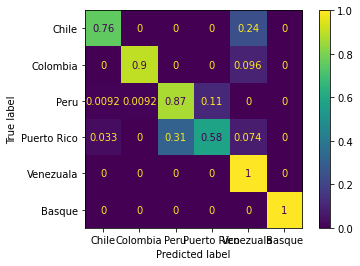

In [28]:
cf_plt.plot()

In [30]:
(sum(yhat == y_true)) / len(yhat)

0.8236331569664903

# Inference

In [ ]:
sample = test[5]['input_values']
ipd_audio(sample, rate = 16000)

In [ ]:
type(test[5]['input_values'])

list

In [ ]:
len(test[5]['input_values'])

80000

In [ ]:
id2label[dialects[idx]['label']]